In [2]:
import numpy as np
import pandas as pd

import pytz
import yfinance as yf
yf.pdr_override()
import pandas_datareader.data as web
from pandas_datareader import data as web

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import calendar
import itertools
import seaborn as sns

import sys
sys.path.append('..')
from bcb import currency
from bcb import sgs
from pyettj import ettj
import pyettj.ettj as ettj

from operator import concat
import datetime
from datetime import datetime as date
from functools import reduce

##############################
#print("Current version of Python is ", sys.version)
import requests
from requests.auth import HTTPBasicAuth
import json

import quantstats as qs
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import update
import timeit
import time
import string
import pygsheets


##############################
#from SWRsimulation.SWRsimulationCE_updated import SWRsimulationCE
#from SWRsimulation.crra_ce_updated import crra_ce
#from SWRsimulation.fin_quant.port_building import build_portfolio, Portfolio, Stock, build_portfolio

#from SWRsimulation.utils.smart_brain import get_clientes, run_single_cliente
#from SWRsimulation.utils.ettj_curves import get_implicita_fwd, get_juro_real_fwd, get_last_date, update_hist_ettj, ret_taxas, update_hist_pre, get_curvas_pre, plot_curves1, plot_curves2, updated_curve_fixed_vert
#from SWRsimulation.utils.tesouro import get_titulos_tesouro, get_hist_titulo, ret_acum_per, ret_acum_ano, get_taxas_ntnb
#from SWRsimulation.utils.data import get_prices, get_stocks, get_fx, get_indexes
#from SWRsimulation.utils.quants import annualised_portfolio_quantities, df_alloc

from utils.smart_brain import *
from utils.ettj_curves import *
from utils.tesouro import *
from utils.data import *
from utils.quants import *
from utils.sb_funcs import *

from functools import partial
import numpy_financial as npf
import scipy.stats as ss
import statsmodels.tsa.stattools as st

import random
import cufflinks as cf
#from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from scipy.stats import norm
from IPython.display import display

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from scipy import optimize
from scipy.optimize import minimize
import ta
from ta.volatility import BollingerBands
import pandas_datareader.data as web
from scipy.interpolate import interp1d
import os
from pandas.tseries.offsets import BDay




pyettj 0.2.4


##### Atualizar Curvas Pré | IPCA

In [3]:
pd.set_option('display.max_columns', 100)

start = pd.Timestamp('2021-01-01 10:00:00', tz=pytz.UTC)
end = date.today() - datetime.timedelta(days= 1)

#file_path = "/Users/Dell/OneDrive//Área de Trabalho/User02/AXIOM/feriados.xlsx"
file_path = os.path.abspath("feriados.xlsx")

feriados = pd.read_excel(file_path)
converted_dates = list(pd.Series(np.array(feriados.Data)).apply(pd.to_datetime).dt.strftime("%Y-%m-%d"))

##### Create multiple vertices (not fixed duration dataset)

vertices = ['2024-01-01', '2025-01-01', '2026-01-01', '2027-01-01',
'2028-01-01', '2029-01-01', '2030-01-01', '2031-01-01', '2033-01-01']

pre = []
for x in range(len(vertices)):
    pre.append(f'Pre_Jan_{vertices[x][:4][2:]}')
ipca = []
for x in range(len(vertices)):
    ipca.append(f'IPCA_Jan_{vertices[x][:4][2:]}')
imp = []
for x in range(len(vertices)):
    imp.append(f'Imp_Jan_{vertices[x][:4][2:]}')

curvas = updated_curve_fixed_vert(end, vertices)

curva_pre = curvas[pre]
curva_pre.index = curvas.index
curva_ipca = curvas[ipca]


In [211]:
#path = "/Users/Dell/OneDrive//Área de Trabalho/User02/AXIOM/Axiom_Feed/curva_pre_.xlsx"
#curva_pre_.to_excel(path)
#curva_pre_ = pd.read_excel(path)
#curva_pre_.set_index('Date', inplace=True)

In [4]:
curva_pre.tail(10)

,Pre_Jan_24,Pre_Jan_25,Pre_Jan_26,Pre_Jan_27,Pre_Jan_28,Pre_Jan_29,Pre_Jan_30,Pre_Jan_31,Pre_Jan_33
Date,,,,,,,,,
2023-04-05,13.46286,12.50143,11.90276,11.81469,11.89178,11.96783,12.08744,12.25280,12.46697
2023-04-06,13.48231,12.57143,11.97333,11.90000,11.97178,12.05783,12.16744,12.33280,12.53688
2023-04-10,13.46000,12.52167,11.93516,11.86548,11.96444,12.05870,12.18512,12.34387,12.55692
2023-04-11,13.38500,12.32636,11.68923,11.60000,11.70667,11.81804,11.94884,12.12065,12.34692
2023-04-12,13.39500,12.35000,11.71667,11.60625,11.71444,11.81870,11.94884,12.11065,12.32692
2023-04-13,13.41500,12.36286,11.64500,11.54645,11.62444,11.70870,11.81884,11.97710,12.42000
2023-04-14,13.42500,12.44286,11.80000,11.65714,11.73222,11.80870,11.91884,12.05710,12.24667
2023-04-17,13.44750,12.46333,11.81560,11.65710,11.72533,11.79957,11.89023,12.01796,12.20000
2023-04-18,13.47750,12.51000,11.89955,11.75000,11.82267,11.88957,11.98023,12.10796,12.28000


##### Gerar tabela Evolução Curva Pré

In [5]:

curva_pre = curva_pre

if end.month == 1:
    one_month_ago = date(end.year-1, end.month+11, end.day).strftime('%Y-%m-%d')
else:
    one_month_ago = date(end.year, end.month-1, end.day).strftime('%Y-%m-%d')
df_month = curva_pre[curva_pre.index > one_month_ago]

one_year_ago = date(end.year-1, end.month, end.day).strftime('%Y-%m-%d')
df_year = curva_pre[curva_pre.index > one_year_ago]

YTD = date(end.year, 1, 1).strftime('%Y-%m-%d')
df_ytd = curva_pre[curva_pre.index > YTD]

one_week = (date.today() - BDay(5)).strftime('%Y-%m-%d')
df_week = curva_pre[curva_pre.index > one_week]
curva_pre.index = pd.to_datetime(curva_pre.index).strftime("%Y-%m-%d")

curva_out = pd.concat([curva_pre.iloc[-1], df_week.iloc[0], df_month.iloc[0], df_year.iloc[0]], axis=1)

col = curva_out.columns[0]
curva_out['pre_termo'] = np.nan

for z in np.arange(1, len(curva_out)):
    
    year_0 = int(str(20) + curva_out.index[z-1].split('_')[-1]) 
    year_1 = int(str(20) + curva_out.index[z].split('_')[-1]) 
        
    days_0 = np.busday_count(curva_out.columns[0], date(year_0, 1, 1).strftime('%Y-%m-%d'))
    days_1 = np.busday_count(curva_out.columns[0], date(year_1, 1, 1).strftime('%Y-%m-%d'))
    
    factor_0 = (curva_out[col][z-1]/100 +1) ** (days_0/252)
    factor_1 = (curva_out[col][z]/100 +1) ** (days_1/252)

    pre_termo = ((factor_1 / factor_0) ** (252 / (days_1 - days_0)) - 1) * 100
    
    curva_out.pre_termo[z] = pre_termo
    curva_final = curva_out.copy()
    curva_final.rename(columns={col: "pre_last", curva_out.columns[1]: "1_W",
                        curva_out.columns[2]: "1_M", curva_out.columns[3]: "1_Y"}, inplace=True)


week_bps = pd.Series((df_week.iloc[-1] - df_week.iloc[0])*100, dtype=np.int64, name='1w_bps')
month_bps = pd.Series((df_month.iloc[-1] - df_month.iloc[0])*100, dtype=np.int64, name='1mo_bps')
year_bps = pd.Series((df_year.iloc[-1] - df_year.iloc[0])*100, dtype=np.int64, name='12mo_bps')
ytd_bps = pd.Series((df_ytd.iloc[-1] - df_ytd.iloc[0])*100, dtype=np.int64, name='2023_bps')

curva_table = pd.concat([curva_final, week_bps, month_bps, ytd_bps, year_bps], axis=1)


curva_table

,pre_last,1_W,1_M,1_Y,pre_termo,1w_bps,1mo_bps,2023_bps,12mo_bps
Pre_Jan_24,13.48833,13.42500,13.27429,12.99909,NaN,6,21,-22,48
Pre_Jan_25,12.60273,12.44286,12.42526,12.54667,11.98826,15,17,-62,5
Pre_Jan_26,12.05636,11.80000,12.09000,12.11571,11.13093,25,-3,-83,-5
Pre_Jan_27,11.95000,11.65714,12.17941,11.89702,11.66279,29,-22,-93,5
Pre_Jan_28,12.06533,11.73222,12.38267,11.81915,12.49368,33,-31,-85,24
Pre_Jan_29,12.16935,11.80870,12.52413,11.80000,12.66192,36,-35,-75,36
Pre_Jan_30,12.28023,11.91884,12.67465,11.81000,12.91450,36,-39,-63,47
Pre_Jan_31,12.40796,12.05710,12.84677,11.86093,13.26761,35,-43,-53,54
Pre_Jan_33,12.58000,12.24667,13.04689,11.95000,13.24365,33,-46,-34,63


In [ ]:
#curva_final.iloc[: , :-2].plot()
curva_final[['pre_last', 'pre_termo']].plot()

##### Compute PCA

In [6]:
horizon_date = None
variance_described = 0.0
residuals_values = pd.DataFrame()
residuals_z_scores = []

def pca_compute(df_, pc_limit):
    
    instruments = df_.columns
    df = df_
    df = df.loc[~(df==0).all(axis=1)]
    df = df.fillna(method='bfill')
    df_factors = ((df-df.mean()) / df.std())
    df_diff = df.diff().dropna()

    pca = PCA(n_components=pc_limit, tol=1e-20, svd_solver='full')
    principal_components = pd.DataFrame(pca.fit_transform(df_diff))
    eigenvectors = pd.DataFrame(columns=instruments, data = pca.components_)
    
    df_pc = pd.DataFrame()
    for i in range(pc_limit):
        _pc = []
        for j in range(len(df_factors)):
            _pc.append(
                np.dot(eigenvectors.iloc[i, :].values, df_factors.iloc[j, :].values))
        df_pc[i] = _pc
    df_pc.index = df_factors.index

    principal_components = df_pc
    principal_components.index = df_factors.index
    principal_components = principal_components.T        

    return pca, principal_components, eigenvectors

##### PCA Analysis | Factors Shape

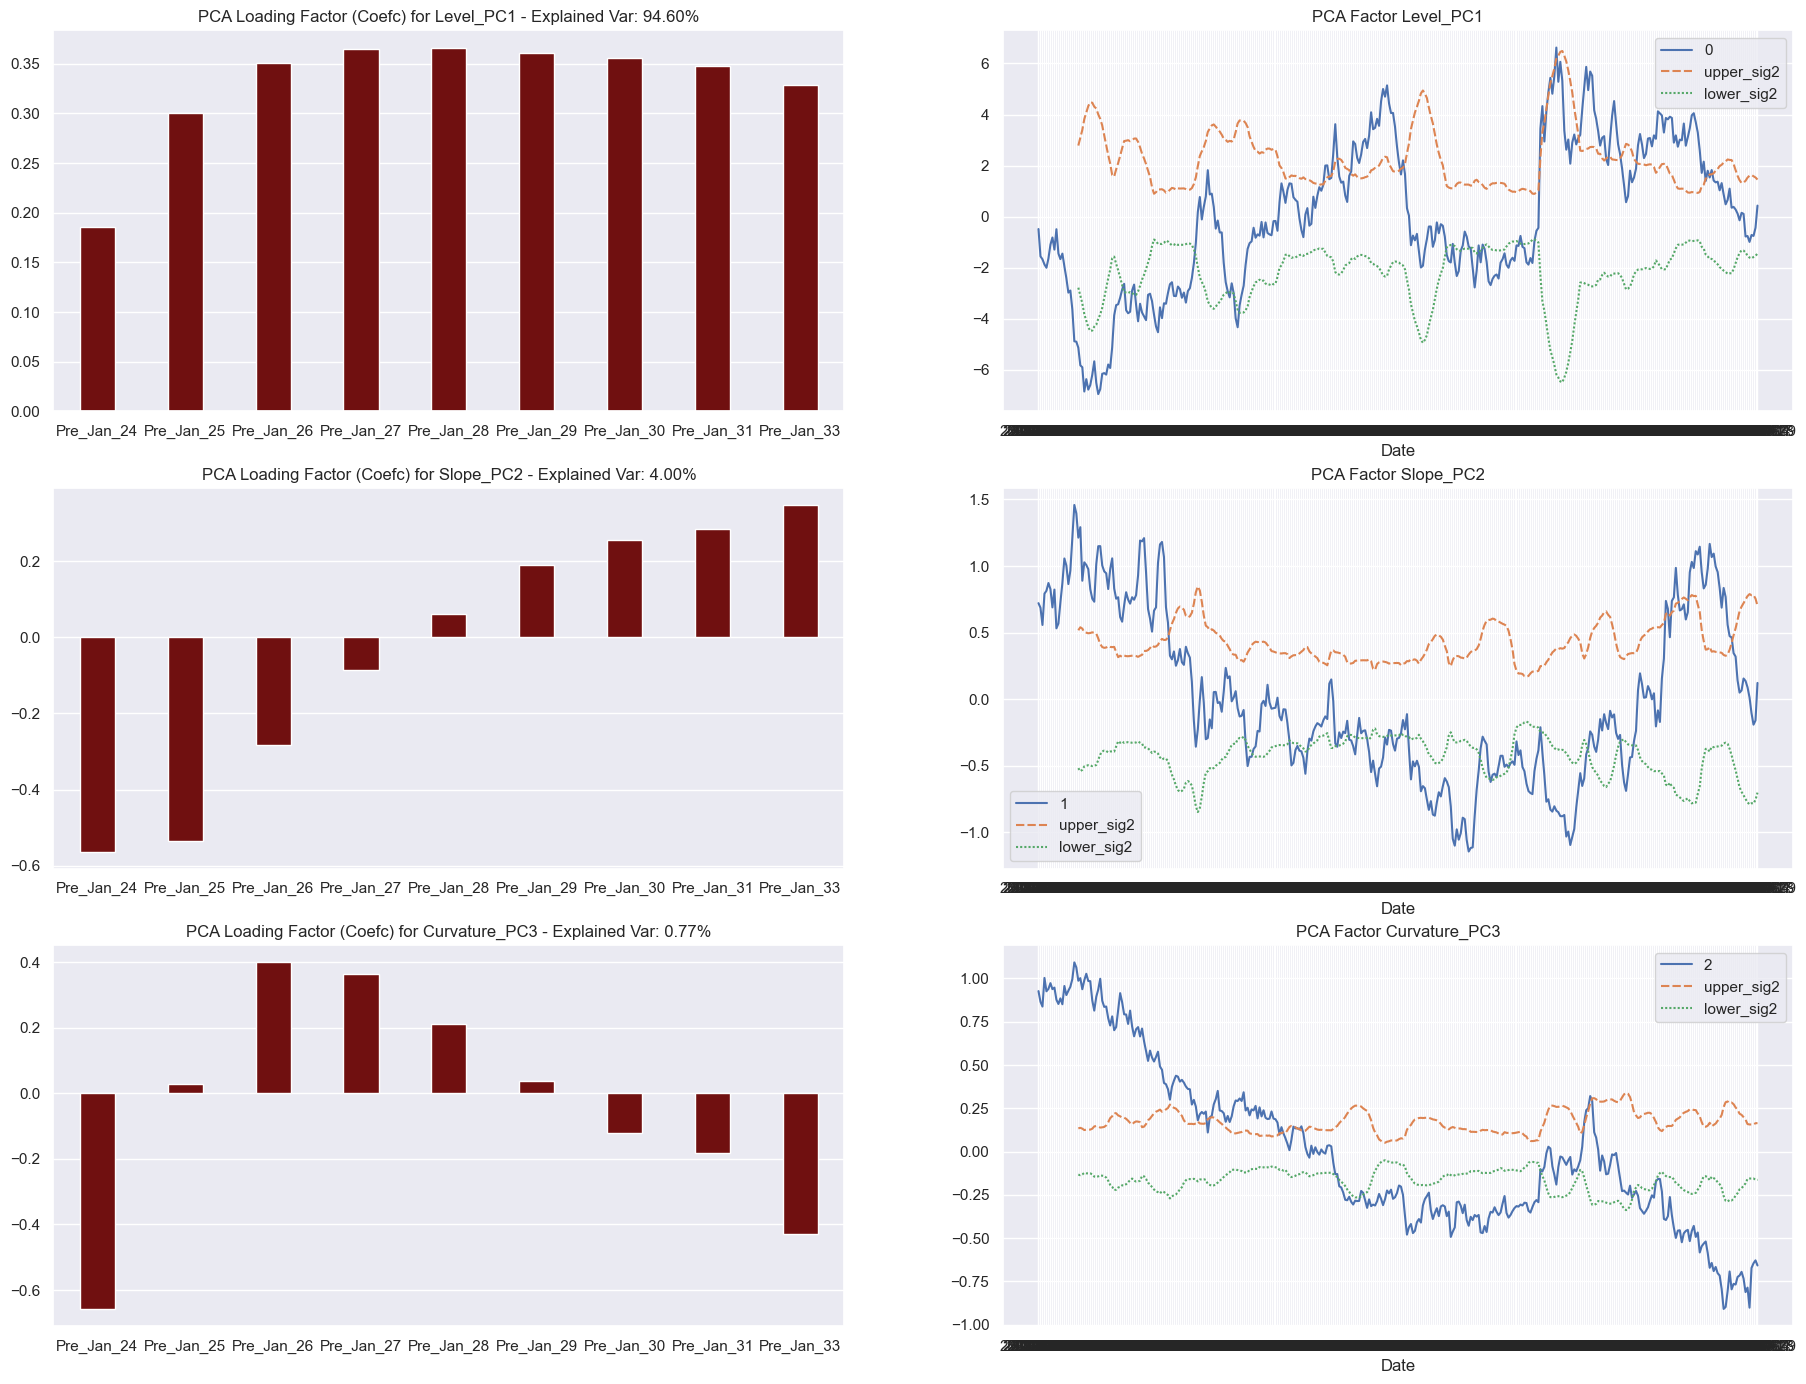

In [8]:
pc_limit = 3
window = 21

pca, principal_components, eigenvectors = pca_compute(curva_pre, pc_limit)
Loading_Factors = eigenvectors.T
Loading_Factors.columns = ['Level_PC1', 'Slope_PC2', 'Curvature_PC3']

variance_described = pd.DataFrame(pca.explained_variance_ratio_).sum()
eigenvalues = pd.DataFrame(pca.explained_variance_)

fig, axs = plt.subplots(3, 2, figsize=(20,16))
for n, pc_ in enumerate(Loading_Factors.columns):
    
    df_pc_single = principal_components.T[[n]]
    sigma = df_pc_single.rolling(window, min_periods=window).std()
    df_pc_single["upper_sig2"] = sigma * 2
    df_pc_single["lower_sig2"] = sigma * -2

    ax = sns.barplot(x = Loading_Factors[pc_].index, y = Loading_Factors[pc_].values, color ='maroon', width = 0.4, ax=axs[n, 0])
    ax.set_title(f'PCA Loading Factor (Coefc) for {pc_} - Explained Var: {f"{pca.explained_variance_ratio_[n] :.2%}"}')
    ax = sns.lineplot(df_pc_single, ax=axs[n, 1])
    ax.set_title(f'PCA Factor {pc_}')

- Loading Factors --> valores > 0 -> indicam que a taxa de juros tem um efeito de "steepening" na curva -> contribui para a curva se inclinar para cima
- valores < 0 -> indicam um efeito de "flattening" -> contribui para a curvase inclinar para baixo

In [9]:
Loading_Factors

,Level_PC1,Slope_PC2,Curvature_PC3
Pre_Jan_24,0.18600,-0.56288,-0.65782
Pre_Jan_25,0.30055,-0.53646,0.02735
Pre_Jan_26,0.35095,-0.28261,0.39844
Pre_Jan_27,0.36436,-0.08513,0.36203
Pre_Jan_28,0.36540,0.06226,0.20949
Pre_Jan_29,0.36058,0.18982,0.03652
Pre_Jan_30,0.35573,0.25659,-0.12192
Pre_Jan_31,0.34798,0.28558,-0.18138
Pre_Jan_33,0.32860,0.34779,-0.42862


##### Coint_Test

In [90]:
Data = pd.DataFrame()
Data = _res[[vert_1,vert_2]]
Data["Ratio"] = _res[vert_2]/_res[vert_1]

Asset_1 = _res[vert_1]
Asset_2 = _res[vert_2]
np.corrcoef(Asset_1, Asset_2)

array([[ 1.        , -0.85161354],
       [-0.85161354,  1.        ]])

In [91]:
def stationarity(a, cutoff = 0.05):
  a = np.ravel(a)
  if st.adfuller(a)[1] < cutoff:
    print('The series is stationary')
    print('p-value =', st.adfuller(a)[1])
  else:
    print('The series is NOT stationary')
    print('p-value =', st.adfuller(a)[1])
stationarity(Asset_1)
stationarity(Asset_2)

def cointegration(a, b):
  if st.coint(a, b)[1] < 0.05:
    print('The series are cointegrated’')
    print('p-value =', st.coint(a, b)[1])    
  else:
    print('The series are NOT cointegrated’')
    print('p-value =', st.coint(a, b)[1])    

cointegration(Asset_1, Asset_2)

The series is NOT stationary
p-value = 0.2493458433661424
The series is NOT stationary
p-value = 0.12500651942226915
The series are NOT cointegrated’
p-value = 0.8137503118667013


In [74]:
import statsmodels.tsa.stattools as ts 
result=ts.coint(Asset_1, Asset_2)[1]
result

0.4114094631556751

In [ ]:
# Set the maximum lag (adjust as needed)
maxlag = 12

# Perform the test
johansen_test = coint_johansen(data_diff, det_order=0, k_ar_diff=maxlag)

# Print the test results
print(johansen_test.lr1)
print(johansen_test.lr2)
print(johansen_test.cvt)  # Critical values for trace statistic
print(johansen_test.cvm)  # Critical values for maximum eigenvalue statistic


##### Create Residuals | Strategy

- Example Residual Slope Yield (RSY) Strategy (-) => compra |toma taxa || (+) vende | dá taxa

- original_data > recon_data => cheap -> too steep --> vende | dá taxa


In [ ]:
# Estimate fair values through a PCA decomposition
# Relative Value analysis
# Ese PCA Analysis for RV rich/cheap analysis and to determine which part of the curve is attractive and appropriate to put on a successful RV trade
# Positioning is discussed below -> DV01 Neutral or Regression Beta flattener

In [10]:
df = curva_pre
pc_limit = 1

pca, principal_components, eigenvectors = pca_compute(curva_pre, pc_limit)
Loading_Factors = eigenvectors.T
#Loading_Factors.columns = ['Level_PC1', 'Slope_PC2', 'Curvature_PC3']
Loading_Factors.columns = ['Level_PC1']

variance_described = pd.DataFrame(pca.explained_variance_ratio_).sum()
eigenvalues = pd.DataFrame(pca.explained_variance_)


df_factors = ((df-df.mean()) / df.std())
recon_X = pd.DataFrame(columns=df.columns, data = np.dot(principal_components.T, eigenvectors))
recon_X.index = principal_components.columns
_res = pd.DataFrame(np.subtract(df_factors, recon_X))*100

In [ ]:
# note last ZERO LINE point
# analysis --> too steep (residuals jan_33 > jan_26) --> room for flattening -> how to position?
#VENDE INCLINAÇÃO --> tomado 26 | dado 33

In [ ]:
#como calcular butterfly residual --> ResidualStrategy = Residual1 – 2 × Residual2 + Residual3

#if len(strategy) == 3:
#    df_str = pd.DataFrame(
#                 (residuals[instruments[0]] - (2 * residuals[instruments[1]]) + residuals[instruments[2]])*100)
#else:
#    df_str = pd.DataFrame((residuals[instruments[1]] - residuals[instruments[0]])*100)

##### Buy/Sell Signals | Conditions

In [ ]:
vert_1 = 'Pre_Jan_26'
vert_2 = 'Pre_Jan_33'

df_res = pd.DataFrame()
df_res['vert_1'] = _res[vert_1]
df_res['vert_2'] = _res[vert_2]

df_res['upper_std_1'] = _res[vert_1].rolling(window, min_periods=window).std().dropna().mean() * 1
df_res['upper_std_2'] = _res[vert_1].rolling(window, min_periods=window).std().dropna().mean() * 2
df_res['lower_std_1'] = _res[vert_1].rolling(window, min_periods=window).std().dropna().mean() * -1
df_res['lower_std_2'] = _res[vert_1].rolling(window, min_periods=window).std().dropna().mean() * -2

df_res.plot()

In [235]:

dt_vert_1 = int(_res.columns[0].split('_')[-1])-int(str(datetime.date.today().year).split('0')[-1]) 
dt_vert_2 = int(_res.columns[-1].split('_')[-1]) - int(str(datetime.date.today().year).split('0')[-1]) 

df_res_sample = pd.DataFrame()
df_res_sample['vert_1'] = _res[vert_1]
df_res_sample['vert_2'] = _res[vert_2]
df_res_sample['pu_vert_1'] = 1 / np.power(1 + df[[vert_1]]/100, dt_vert_1)     
df_res_sample['pu_vert_2'] = 1 / np.power(1 + df[[vert_2]]/100, dt_vert_2)     

def get_df_signals_pos(df_res_sample, window):

    df_res = df_res_sample[window:].copy()
    df_res['strategy'] = np.nan
    df_res['str_std_plus_2'] = np.nan
    df_res['trade_pos'] = np.nan
    df_res['pos_strategy'] = np.nan
    df_res['pnl_vert_1'] = np.nan
    df_res['pnl_vert_2'] = np.nan

    for i in range(len(df_res)):

        if df_res.vert_2[i] > df_res.vert_1[i]: # too steep -> vende inclinação | flattening is more likely
            pos_curto = -1 #compra curto
            pos_longo = 1  #vende longo   
            df_res.trade_pos[i] = 'short_inc'  
            
        elif df_res.vert_2[i] < df_res.vert_1[i]: # too flattened -> compra inclinação | steepening is more likely 
            pos_curto = 1 #vende curto
            pos_longo = -1 #compra longo             
            df_res.trade_pos[i] = 'long_inc'         

        df_res.strategy[i] = df_res.vert_1[i]*pos_curto + df_res.vert_2[i]*pos_longo
        
        strategy_in_sample = df_res_sample.vert_1[:i + window]*pos_curto + df_res_sample.vert_2[:i + window]*pos_longo #expanded window for estimating mean of std (strategy) --> trigger for entering position
            
        df_res.str_std_plus_2[i] =  strategy_in_sample.rolling(window, min_periods=window).std().dropna().mean() * 2    
        
        if df_res.strategy[i] > df_res.str_std_plus_2[i]:# or df_res.strategy[i] < df_res.str_std_minus_2[i]:
            df_res.pos_strategy[i] = 1 #open position  
            df_res.trade_pos[i] = df_res.trade_pos[i]      
            #df_res.pnl_vert_1[i] = pos_curto * df_res.pu_vert_1[i]
            #df_res.pnl_vert_2[i] = pos_longo * df_res.pu_vert_2[i]
        else:
            df_res.pos_strategy[i] = 0
            df_res.trade_pos[i] = None
            #df_res.pnl_vert_1[i] = 0
            #df_res.pnl_vert_2[i] = 0
    
    return df_res
  

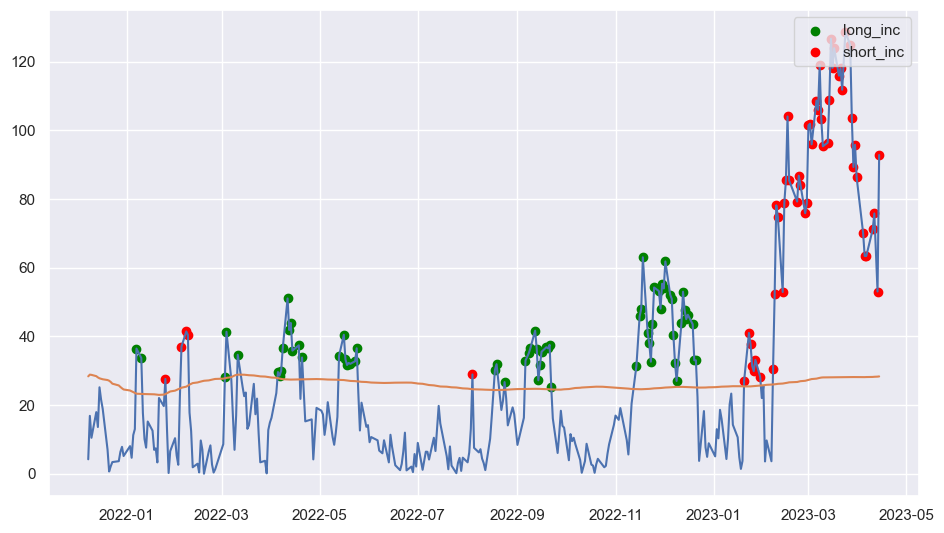

In [236]:
df_res = get_df_signals_pos(df_res_sample, window)

#df_res[['strategy', 'str_std_plus_2']].plot()
plt.plot(df_res['strategy']) 
plt.plot(df_res['str_std_plus_2']) 
plt.scatter(df_res.index, df_res["strategy"].where(df_res["trade_pos"]=='long_inc', np.nan), color="green", label="long_inc")
plt.scatter(df_res.index, df_res["strategy"].where(df_res["trade_pos"]=='short_inc', np.nan), color="red", label="short_inc")
plt.legend(loc="upper right")
#plt.title("Moving Average Crossover")
plt.show()

In [12]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)

df_full = pd.merge(df_res, df[[vert_1, vert_2]], on="Date")

print('sum_positions_triggers:', df_full.pos_strategy.sum())
print('total data points:', len(df_full))

sum_positions_triggers: 119.0
total data points: 328


In [14]:
#Holding_period = 2

def get_pnl_strategy(df, Holding_period):

  df_full = df.copy()
  for i in range(len(df_full)):
    try:    
      if df_full.trade_pos[i] == 'long_inc':      
        df_full.pnl_vert_1[i+Holding_period] = (df_full.pu_vert_1[i+Holding_period]/df_full.pu_vert_1[i])-1 #VENDE CURTO
        df_full.pnl_vert_2[i+Holding_period] = (df_full.pu_vert_2[i]/df_full.pu_vert_2[i+Holding_period])-1 #COMPRA LONGO
      
      elif df_full.trade_pos[i] == 'short_inc':      
        df_full.pnl_vert_1[i+Holding_period] = (df_full.pu_vert_1[i]/df_full.pu_vert_1[i+Holding_period])-1  #COMPRA CURTO      
        df_full.pnl_vert_2[i+Holding_period] = (df_full.pu_vert_2[i+Holding_period]/df_full.pu_vert_2[i])-1 #VENDE LONGO    
      else:
        df_full.pnl_vert_1[i+Holding_period] = 0
        df_full.pnl_vert_2[i+Holding_period] = 0
    except IndexError:
      pass
  df_full.pos_res = (df_full['pnl_vert_1']+1)*(df_full['pnl_vert_2']+1)-1
  df_full['ret_acum_pnl'] = (1+df_full.pos_res).cumprod()

  return df_full    


In [ ]:

##########################################################

fig, axs = plt.subplots(3, 2, figsize=(20,16))
hp_values = [5, 10, 20]
for n, hp in enumerate(hp_values):
  
  df = get_pnl_strategy(df_full, hp)  
  ret_total = np.round((df.ret_acum_pnl[-1]-1)*100,2)
  start_dt_ytd = pd.to_datetime(df.index[0]).strftime("%Y-%m-%d")
  end_dt_ytd = pd.to_datetime(df.index[-1]).strftime("%Y-%m-%d")
  dif_days = np.busday_count(start_dt_ytd, end_dt_ytd)
  ret_anual = np.round(((ret_total/100+1)**(252/dif_days)-1) *100,2)

  ax = sns.lineplot(df.ret_acum_pnl, ax=axs[n, 0])
  ax.set_title(f'ret_acum_pnl for Holding_period {hp} days | ret_tt {ret_total} | ret_anual {ret_anual} ')

  df_ = get_pnl_strategy(df_full, hp*3)
  ret_total_ = np.round((df_.ret_acum_pnl[-1]-1)*100,2)
  start_dt_ytd = pd.to_datetime(df_.index[0]).strftime("%Y-%m-%d")
  end_dt_ytd = pd.to_datetime(df_.index[-1]).strftime("%Y-%m-%d")
  dif_days = np.busday_count(start_dt_ytd, end_dt_ytd)
  ret_anual_ = np.round(((ret_total_/100+1)**(252/dif_days)-1) *100,2)
  
  ax = sns.lineplot(df_.ret_acum_pnl, ax=axs[n, 1])
  ax.set_title(f'ret_acum_pnl for Holding_period {hp*3} days | ret_tt {ret_total_} | ret_anual {ret_anual_} ')    
  


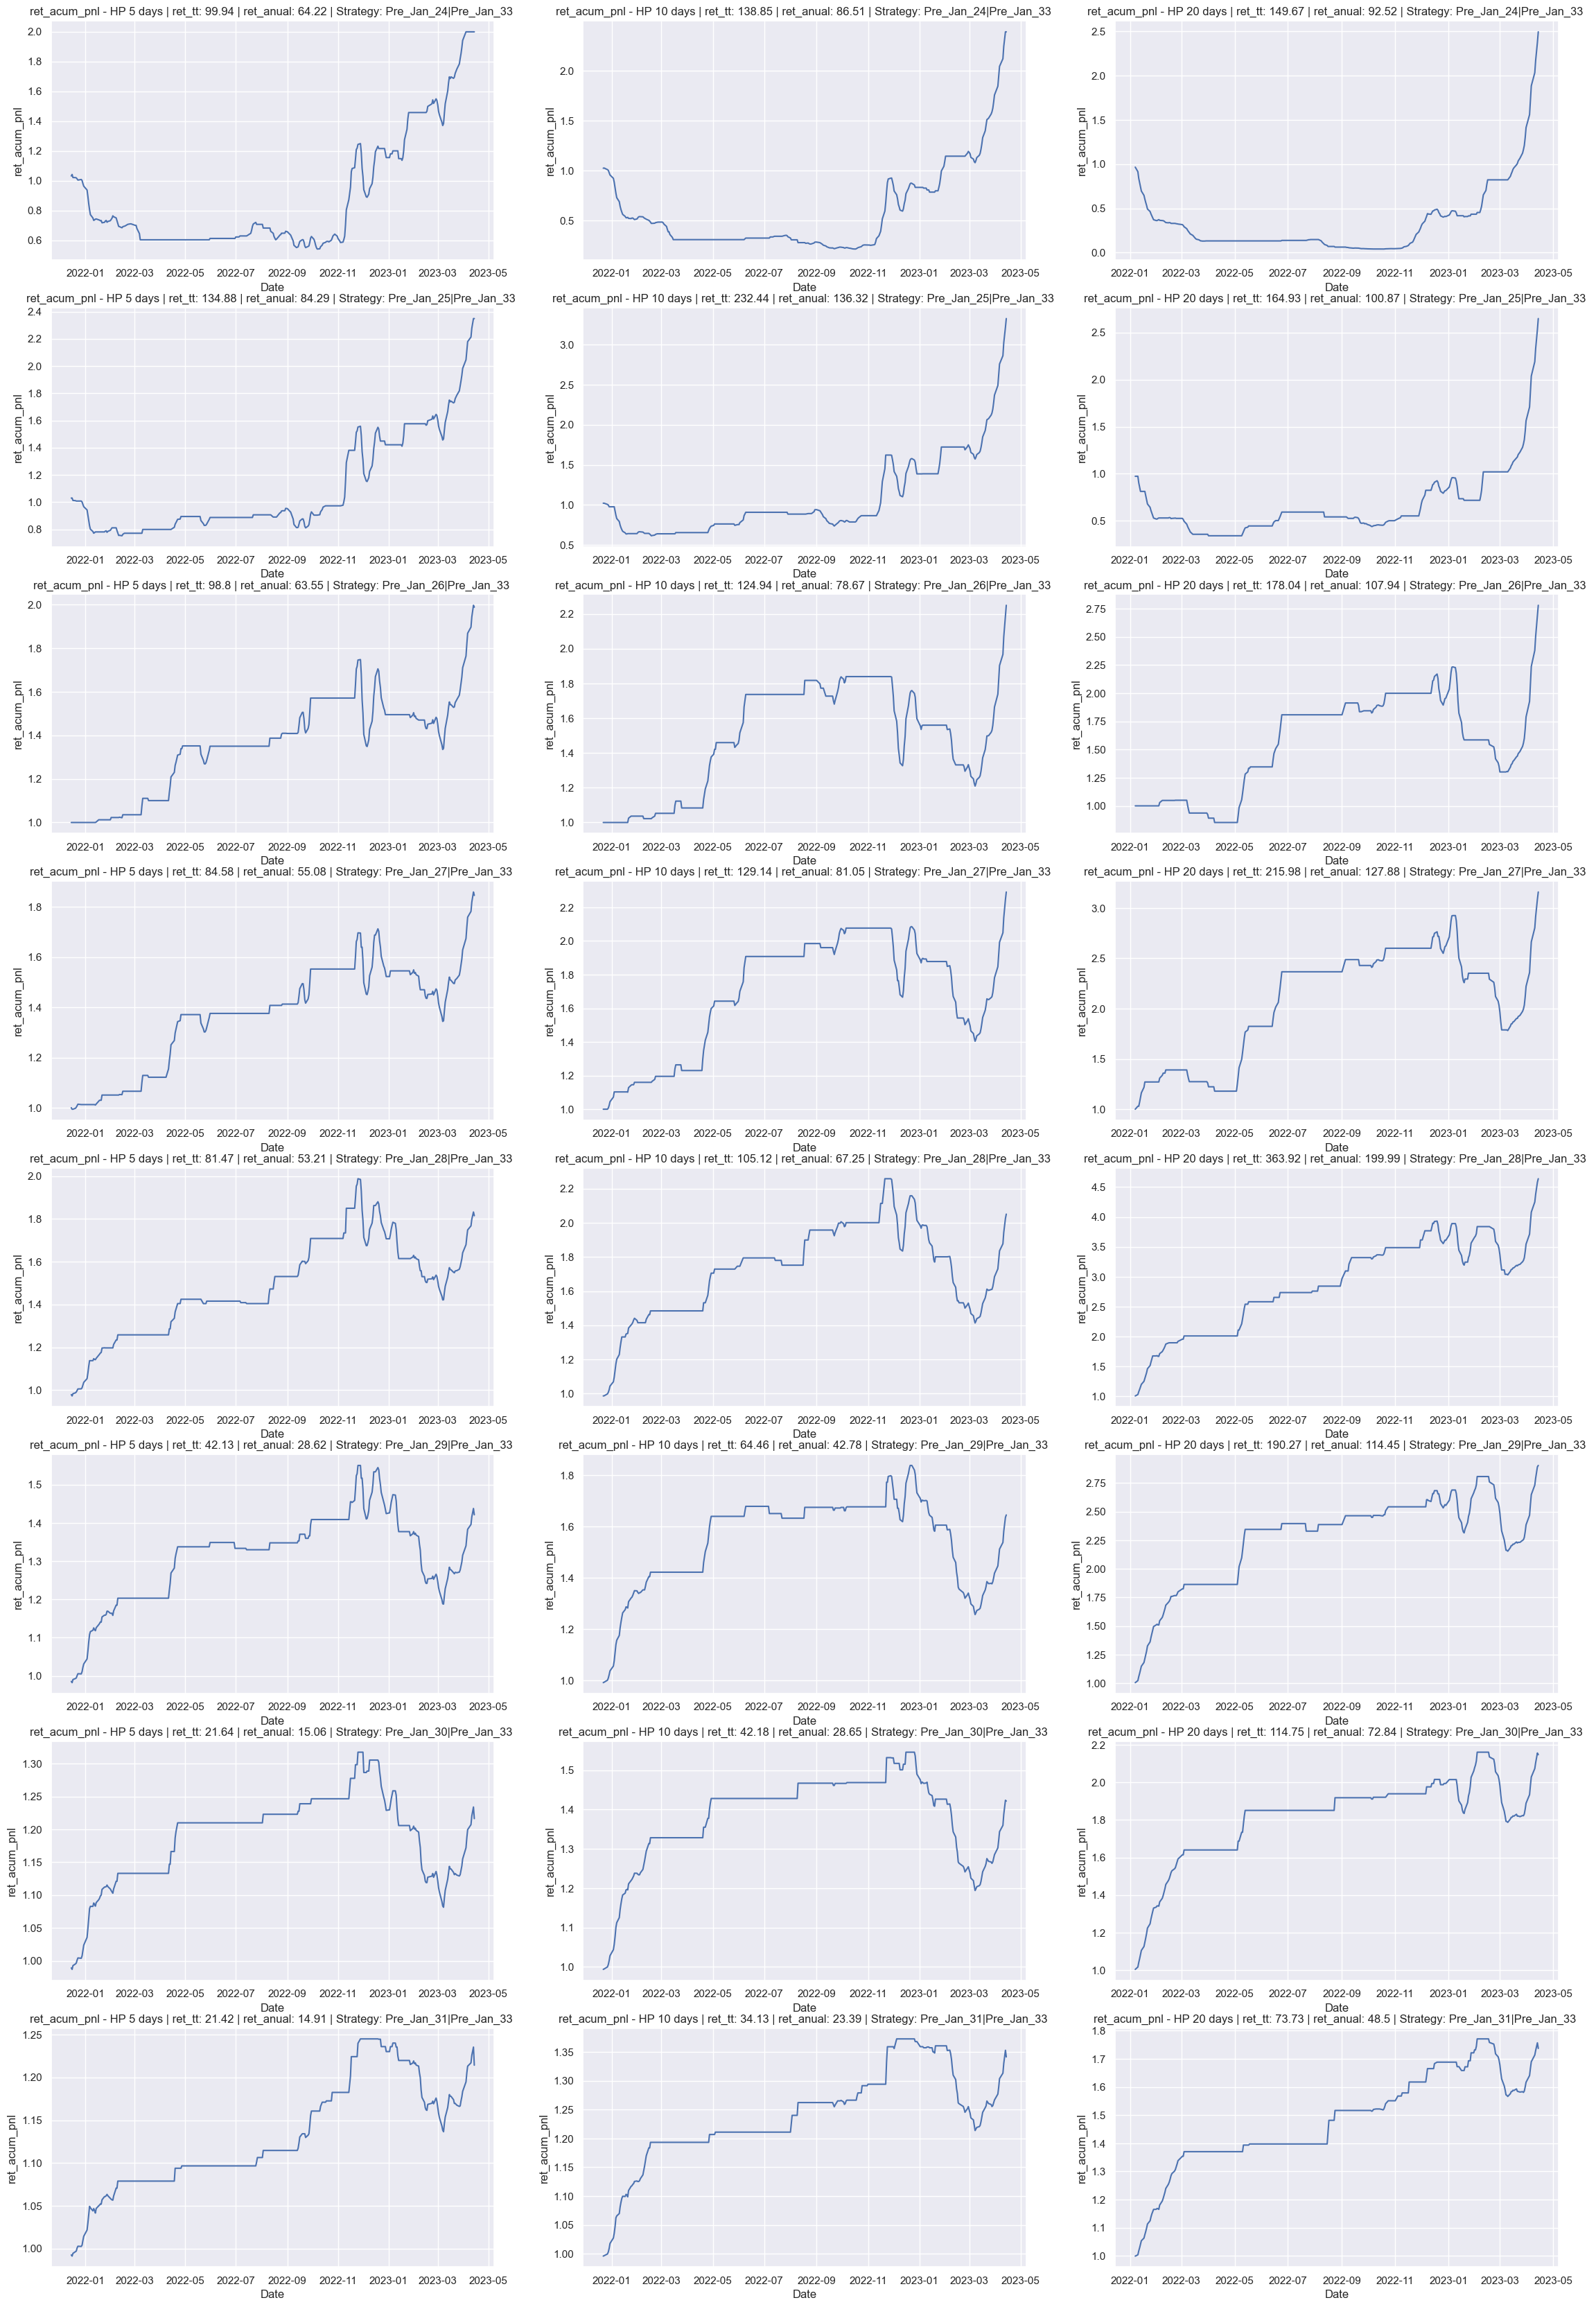

In [237]:
fig, axs = plt.subplots(len(_res.columns[:-1]), 3, figsize=(25,40))

for p, v in enumerate(_res.columns[:-1]):
    
    vert_1 = v
    vert_2 = _res.columns[-1]

    dt_vert_1 = int(vert_1.split('_')[-1])-int(str(datetime.date.today().year).split('0')[-1]) 
    dt_vert_2 = int(vert_2.split('_')[-1]) - int(str(datetime.date.today().year).split('0')[-1]) 

    df_res_sample = pd.DataFrame()
    df_res_sample['vert_1'] = _res[vert_1]
    df_res_sample['vert_2'] = _res[vert_2]
    df_res_sample['pu_vert_1'] = 1 / np.power(1 + df[[vert_1]]/100, dt_vert_1)     
    df_res_sample['pu_vert_2'] = 1 / np.power(1 + df[[vert_2]]/100, dt_vert_2)  
    
    df_res = get_df_signals_pos(df_res_sample, window)
    df_full = pd.merge(df_res, df[[vert_1, vert_2]], on="Date")

    hp_values = [5, 10, 20]
    
    for n, hp in enumerate(hp_values):
    
        df_out = get_pnl_strategy(df_full, hp)  
        ret_total = np.round((df_out.ret_acum_pnl[-1]-1)*100,2)
        start_dt = pd.to_datetime(df_out.index[0]).strftime("%Y-%m-%d")
        end_dt = pd.to_datetime(df_out.index[-1]).strftime("%Y-%m-%d")
        dif_days = np.busday_count(start_dt, end_dt)
        ret_anual = np.round(((ret_total/100+1)**(252/dif_days)-1) *100,2)
        strat = (vert_1 + '|' + vert_2)

        ax = sns.lineplot(df_out.ret_acum_pnl, ax=axs[p, n])
        ax.set_title(f'ret_acum_pnl - HP {hp} days | ret_tt: {ret_total} | ret_anual: {ret_anual} | Strategy: {strat} ')

        
        

In [ ]:
names = ['Strategy', 'ret_total', 'ret_ano', 'HP']
results_aux = pd.DataFrame(columns=names)
results = pd.DataFrame(columns=names)

for v in _res.columns[:-1]:
    
    vert_1 = v
    vert_2 = _res.columns[-1]
    dt_vert_1 = int(vert_1.split('_')[-1])-int(str(datetime.date.today().year).split('0')[-1]) 
    dt_vert_2 = int(vert_2.split('_')[-1]) - int(str(datetime.date.today().year).split('0')[-1]) 

    df_res_sample = pd.DataFrame()
    df_res_sample['vert_1'] = _res[vert_1]
    df_res_sample['vert_2'] = _res[vert_2]
    df_res_sample['pu_vert_1'] = 1 / np.power(1 + df[[vert_1]]/100, dt_vert_1)     
    df_res_sample['pu_vert_2'] = 1 / np.power(1 + df[[vert_2]]/100, dt_vert_2)  
    
    df_res = get_df_signals_pos(df_res_sample, window)
    df_full = pd.merge(df_res, df[[vert_1, vert_2]], on="Date")    
    hp_values = [5, 10, 20]    

    for n, hp in enumerate(hp_values):
    
        df_out = get_pnl_strategy(df_full, hp)          
        ret_total = np.round((df_out.ret_acum_pnl[-1]-1)*100,2)
        start_dt = pd.to_datetime(df_out.index[0]).strftime("%Y-%m-%d")
        end_dt = pd.to_datetime(df_out.index[-1]).strftime("%Y-%m-%d")
        dif_days = np.busday_count(start_dt, end_dt)
        ret_anual = np.round(((ret_total/100+1)**(252/dif_days)-1) *100,2)
        strat = (vert_1 + '|' + vert_2)
        results_aux.loc[0] = [strat, ret_total, ret_anual, hp]                
        results = pd.concat([results, results_aux], axis=0)
        

results

In [45]:
results.set_index('Strategy', inplace=True)
results.sort_values(by='ret_total', ascending=False)

,ret_total,ret_ano,HP
Strategy,,,
Pre_Jan_28|Pre_Jan_33,314.89000,179.37000,20
Pre_Jan_29|Pre_Jan_33,199.14000,120.60000,20
Pre_Jan_27|Pre_Jan_33,191.75000,116.65000,20
Pre_Jan_25|Pre_Jan_33,151.39000,94.57000,10
Pre_Jan_26|Pre_Jan_33,138.91000,87.55000,20
Pre_Jan_24|Pre_Jan_33,124.35000,79.22000,10
Pre_Jan_24|Pre_Jan_33,117.42000,75.21000,20
Pre_Jan_27|Pre_Jan_33,113.88000,73.14000,10
Pre_Jan_25|Pre_Jan_33,113.48000,72.91000,5


In [52]:

res_hp_1 = results[results.HP == results.HP.unique()[0]]
res_hp_1 = res_hp_1.sort_values(by='ret_total', ascending=False)

res_hp_2 = results[results.HP == results.HP.unique()[1]]
res_hp_2 = res_hp_2.sort_values(by='ret_total', ascending=False)

res_hp_3 = results[results.HP == results.HP.unique()[2]]
res_hp_3 = res_hp_3.sort_values(by='ret_total', ascending=False)

display(res_hp_1)
display(res_hp_2)
display(res_hp_3)

,ret_total,ret_ano,HP
Strategy,,,
Pre_Jan_25|Pre_Jan_33,113.48000,72.91000,5
Pre_Jan_24|Pre_Jan_33,99.94000,64.92000,5
Pre_Jan_26|Pre_Jan_33,91.47000,59.84000,5
Pre_Jan_27|Pre_Jan_33,81.89000,54.03000,5
Pre_Jan_28|Pre_Jan_33,70.78000,47.18000,5
Pre_Jan_29|Pre_Jan_33,46.31000,31.62000,5
Pre_Jan_31|Pre_Jan_33,27.25000,19.01000,5
Pre_Jan_30|Pre_Jan_33,16.53000,11.68000,5


,ret_total,ret_ano,HP
Strategy,,,
Pre_Jan_25|Pre_Jan_33,151.39000,94.57000,10
Pre_Jan_24|Pre_Jan_33,124.35000,79.22000,10
Pre_Jan_27|Pre_Jan_33,113.88000,73.14000,10
Pre_Jan_26|Pre_Jan_33,102.12000,66.21000,10
Pre_Jan_28|Pre_Jan_33,87.82000,57.64000,10
Pre_Jan_29|Pre_Jan_33,64.69000,43.37000,10
Pre_Jan_31|Pre_Jan_33,36.45000,25.16000,10
Pre_Jan_30|Pre_Jan_33,34.14000,23.62000,10


,ret_total,ret_ano,HP
Strategy,,,
Pre_Jan_28|Pre_Jan_33,314.89000,179.37000,20
Pre_Jan_29|Pre_Jan_33,199.14000,120.60000,20
Pre_Jan_27|Pre_Jan_33,191.75000,116.65000,20
Pre_Jan_26|Pre_Jan_33,138.91000,87.55000,20
Pre_Jan_24|Pre_Jan_33,117.42000,75.21000,20
Pre_Jan_25|Pre_Jan_33,101.25000,65.70000,20
Pre_Jan_30|Pre_Jan_33,97.41000,63.41000,20
Pre_Jan_31|Pre_Jan_33,72.21000,48.06000,20


##### Backtesting
----

In [ ]:
start = pd.Timestamp('2023-04-12 10:00:00')

curva_pre.index = pd.to_datetime(curva_pre.index)
curva_pre_dt = curva_pre[curva_pre.index >= pd.to_datetime(start)]

- Calcular DV01 | Duration | Convexidade de cada vértice (taxas históricas)

In [13]:
shift_days = 180
#shift_days = len(curva_pre_dt)
delta = 0.01 #(bps)
curva_pre_filter = curva_pre[-shift_days:].copy()
#curva_pre_filter = curva_pre_dt.copy()

dv01_out = curva_pre_filter.copy()
dur_out = curva_pre_filter.copy()
taxa_out = curva_pre_filter.copy()
conv_out_ = curva_pre_filter.copy()

for col, vert_date in enumerate(vertices):    
    for idx, n in enumerate(curva_pre_filter.index):        
        days = np.busday_count(n, vert_date, holidays=converted_dates) #n.strftime("%Y-%m-%d")
        taxa = curva_pre_filter.iloc[idx,col]
        dv01_val, duration, convexidade = dv01(days, taxa/100, delta)
        taxa_out.iloc[idx,col] = taxa
        dv01_out.iloc[idx,col] = dv01_val
        conv_out_.iloc[idx,col] = convexidade
        dur_out.iloc[idx,col] = duration        

#display('DV01', dv01_out)
#display('Duration',dur_out)
#display('Convexidade',conv_out_)

In [14]:
start = pd.Timestamp('2023-04-12 10:00:00').strftime('%Y-%m-%d')

vert_1 = 'Pre_Jan_26'
vert_2 = 'Pre_Jan_33'
pos_curto = -1
pos_longo = 1

df_dif_res_ts = pd.DataFrame(_res[vert_1]*pos_curto + _res[vert_2]*pos_longo)

df_dif_res_ts.index = pd.to_datetime(curva_pre.index)
df_res_trade = df_dif_res_ts[df_dif_res_ts.index == start][0][0]

Position Slope Strategy @ BPS: 69.08


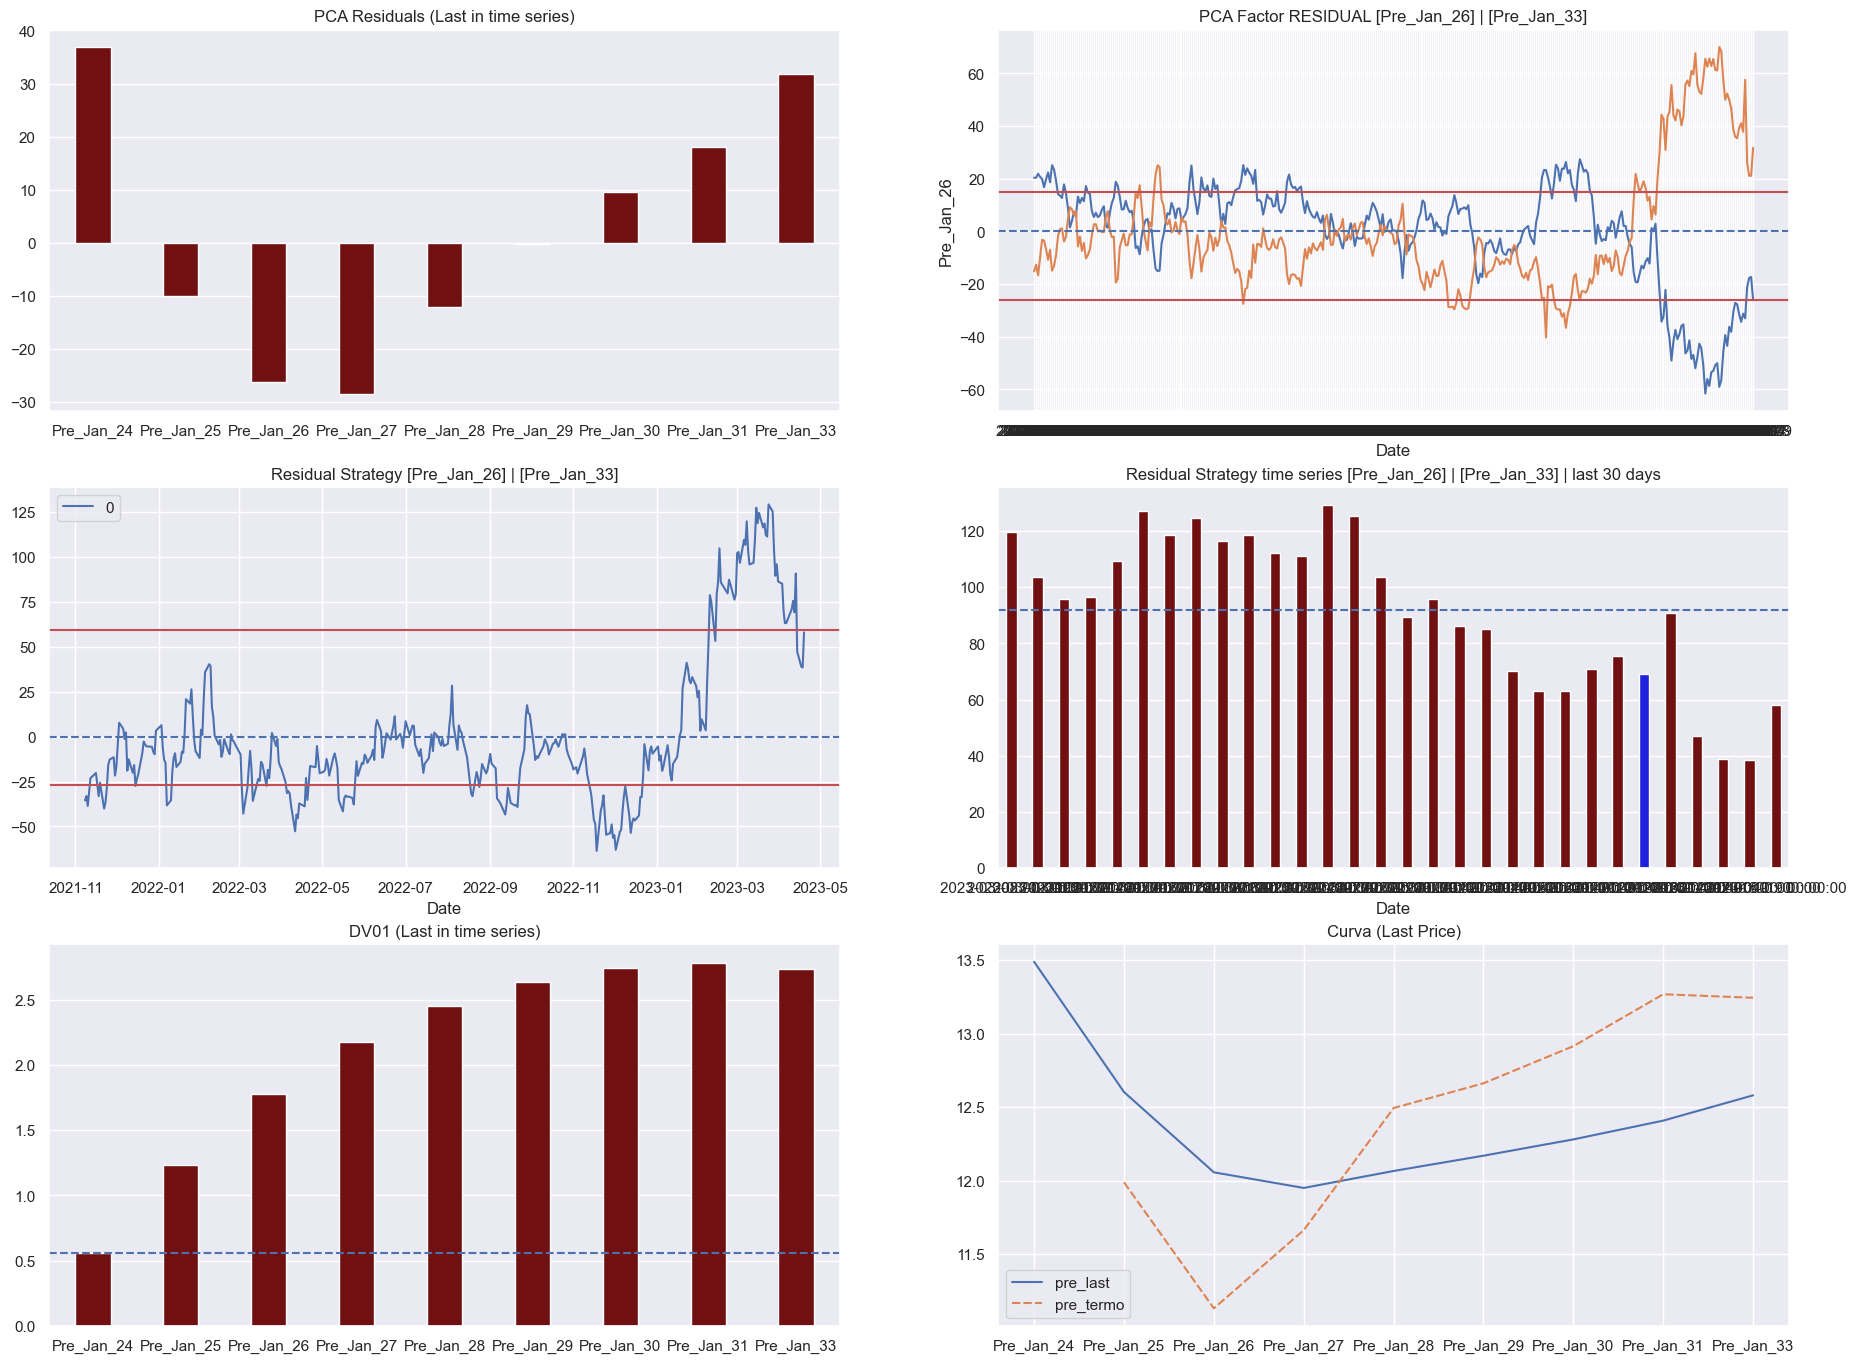

In [15]:
sig_vert_1 = _res[vert_1].rolling(window, min_periods=window).mean()
sig_vert_2 = _res[vert_2].rolling(window, min_periods=window).mean()

fig, axs = plt.subplots(3, 2, figsize=(20,16))

ax = sns.barplot(x = _res.tail(1).T.index, y = _res.tail(1).T.values.flatten(), color ='maroon', width = 0.4, ax=axs[0, 0])
ax.set_title('PCA Residuals (Last in time series)')

ax = sns.lineplot(_res[vert_1], ax=axs[0, 1])
ax = sns.lineplot(_res[vert_2], ax=axs[0, 1])
#ax.set_title(f'PCA Factor RESIDUAL [{vert_1}]')
ax.set_title(f'PCA Factor RESIDUAL [{vert_1}] | [{vert_2}]')
ax.axhline(_res[vert_1].mean(), ls='--')
ax.axhline(np.quantile(sig_vert_1.dropna(), 0.9), color='r')
ax.axhline(np.quantile(sig_vert_1.dropna(), 0.1), color='r')


#ax = sns.barplot(x = _res.tail(1).T.index, y = _res.tail(1).T.values.flatten(), color ='maroon', width = 0.4, ax=axs[1, 0])
#ax.set_title('PCA Residuals (Last in time series)')

###################################

ax = sns.lineplot(df_dif_res_ts, ax=axs[1, 0])
#ax = sns.lineplot(_res[vert_1], ax=axs[1, 0])
#ax = sns.lineplot(_res[vert_2], ax=axs[1, 0])
ax.set_title(f'Residual Strategy [{vert_1}] | [{vert_2}]')
ax.axhline(df_dif_res_ts.mean()[0], ls='--')
ax.axhline(np.quantile(df_dif_res_ts.rolling(window, min_periods=window).mean().dropna(), 0.9), color='r')
ax.axhline(np.quantile(df_dif_res_ts.rolling(window, min_periods=window).mean().dropna(), 0.1), color='r')

###################################

shift_ = 30
values = df_dif_res_ts.tail(shift_).values.flatten()
clrs = ['blue' if (x == df_res_trade) else 'maroon' for x in values]

x_ = df_dif_res_ts.tail(shift_).index# .strftime("%Y-%m-%d")
ax = sns.barplot(x = x_, y = values, palette=clrs, color ='maroon', width = 0.4, ax=axs[1, 1])
ax.set_title(f'Residual Strategy time series [{vert_1}] | [{vert_2}] | last {shift_} days')
ax.axhline(df_dif_res_ts.tail(shift_).mean()[0], ls='--')


#x__ = dv01_out.tail(1).index.strftime("%Y-%m-%d")
ax = sns.barplot(x = dv01_out.tail(1).T.index, y = dv01_out.tail(1).T.values.flatten(), color ='maroon', width = 0.4, ax=axs[2, 0])
ax.set_title(f'DV01 (Last in time series)')
ax.axhline(dv01_out.tail(1).mean()[0], ls='--')

ax = sns.lineplot(curva_final[['pre_last', 'pre_termo']], ax=axs[2, 1])
ax.set_title(f'Curva (Last Price)')

print('Position Slope Strategy @ BPS:', np.round(df_res_trade,2))


##### Trading & Risk Analysis
---

- Setar parametros da Estratégia RV | Posição | Vértices | Qty Cts | Taxas

In [18]:
vert_1 = 'Pre_Jan_26'
vert_2 = 'Pre_Jan_33'
pos_pu_1 = 1
pos_pu_2 = -1

qty_cts_1 = 15 
qty_cts_2 = 10 

#definir taxas fechadas -> estratégia
start_trade = pd.Timestamp('2023-04-14 10:00:00').strftime("%Y-%m-%d")
taxa_vert_1 = 0.11645
taxa_vert_2 = 0.1242
du_vert_1 =  np.busday_count(start_trade, date(int('20' + vert_1.split('_')[-1]), 1, 2).strftime("%Y-%m-%d"), holidays=converted_dates)
du_vert_2 = np.busday_count(start_trade, date(int('20' + vert_2.split('_')[-1]), 1, 3).strftime("%Y-%m-%d"), holidays=converted_dates)  

pu_vert_1 = 1e5 / (taxa_vert_1 + 1) ** (du_vert_1/252)
pu_vert_2 = 1e5 / (taxa_vert_2 + 1) ** (du_vert_2/252)
pu_slope_inicial =  pu_vert_1*pos_pu_1*qty_cts_1 + pu_vert_2*pos_pu_2*qty_cts_2

print(pu_vert_1)
print(pu_vert_2)
print(pu_slope_inicial)

74124.31493754624
32143.985911556756
790424.8649476261


- calcular pnl posição DI - ver se é coerente com a variação do risco total
- definir VaR% (dia/semana)
- definir stop 

In [ ]:
confidence_level = 0.05

relative_value_position = pd.DataFrame()
relative_value_position[f'dur_{vert_1}'] = dur_out[vert_1]
relative_value_position[f'dur_{vert_2}'] = dur_out[vert_2]
relative_value_position[f'convex_{vert_1}'] = conv_out_[vert_1]
relative_value_position[f'convex_{vert_2}'] = conv_out_[vert_2]
relative_value_position[f'dv01_{vert_1}'] = dv01_out[vert_1]
relative_value_position[f'dv01_{vert_2}'] = dv01_out[vert_2]

relative_value_position[f'taxa_{vert_1}'] = curva_pre_filter[vert_1]
relative_value_position[f'taxa_{vert_2}'] = curva_pre_filter[vert_2]

relative_value_position[f'pu_{vert_1}'] = 1e5 / ((taxa_out[vert_1]/100 + 1) ** dur_out[vert_1])
relative_value_position[f'pu_{vert_2}'] = 1e5 / ((taxa_out[vert_2]/100 + 1) ** dur_out[vert_2])

#relative_value_position[f'diff_pu_{vert_1}'] = relative_value_position[f'pu_{vert_1}'].diff() * qty_cts_1
#relative_value_position[f'diff_pu_{vert_2}'] = relative_value_position[f'pu_{vert_2}'].diff() * qty_cts_2

relative_value_position[f'slope_dif_taxa_bps'] = (curva_pre_filter[vert_2] - curva_pre_filter[vert_1]) * 100
relative_value_position[f'slope_pnl_pu'] = relative_value_position[f'pu_{vert_1}'].diff() * qty_cts_1 * pos_pu_1 + relative_value_position[f'pu_{vert_2}'].diff() * qty_cts_2 * pos_pu_2


relative_value_position[f'yield_change_{vert_1}'] = curva_pre_filter[vert_1].pct_change().dropna()
relative_value_position[f'yield_change_{vert_2}'] = curva_pre_filter[vert_2].pct_change().dropna()

relative_value_position['slope_dur_1:1'] = relative_value_position[f'dur_{vert_2}'] - relative_value_position[f'dur_{vert_1}'] 
relative_value_position['slope_convex_1:1'] = relative_value_position[f'convex_{vert_2}']  - relative_value_position[f'convex_{vert_1}'] 
relative_value_position['slope_dv01_1:1'] = relative_value_position[f'dv01_{vert_2}']  - relative_value_position[f'dv01_{vert_1}'] 

relative_value_position["dur_risk_1:1"] = relative_value_position["slope_dur_1:1"] * relative_value_position[f'yield_change_{vert_1}'] - relative_value_position["slope_dur_1:1"] * relative_value_position[f'yield_change_{vert_2}']
relative_value_position["convex_risk_1:1"] = 0.5 * relative_value_position["slope_convex_1:1"] * (relative_value_position[f'yield_change_{vert_1}'] ** 2) - 0.5 * relative_value_position["slope_convex_1:1"] * (relative_value_position[f'yield_change_{vert_2}'] ** 2)
relative_value_position["total_risk_1:1"] = relative_value_position["dur_risk_1:1"] + relative_value_position["convex_risk_1:1"]


relative_value_position['slope_dur'] = relative_value_position[f'dur_{vert_2}'] * qty_cts_2 - relative_value_position[f'dur_{vert_1}'] * qty_cts_1
relative_value_position['slope_convex'] = relative_value_position[f'convex_{vert_2}'] * qty_cts_2 - relative_value_position[f'convex_{vert_1}'] * qty_cts_1
relative_value_position['slope_dv01'] = relative_value_position[f'dv01_{vert_2}'] * qty_cts_2 - relative_value_position[f'dv01_{vert_1}'] * qty_cts_1

relative_value_position["dur_risk"] = relative_value_position["slope_dur"] * relative_value_position[f'yield_change_{vert_1}'] - relative_value_position["slope_dur"] * relative_value_position[f'yield_change_{vert_2}']
relative_value_position["convex_risk"] = 0.5 * relative_value_position["slope_convex"] * (relative_value_position[f'yield_change_{vert_1}'] ** 2) - 0.5 * relative_value_position["slope_convex"] * (relative_value_position[f'yield_change_{vert_2}'] ** 2)
relative_value_position["total_risk"] = relative_value_position["dur_risk"] + relative_value_position["convex_risk"]

relative_value_position["std_rolling"] = relative_value_position["total_risk"].rolling(window=21).std() * np.sqrt(252)  

relative_value_position["Daily_VaR"] = -relative_value_position["total_risk"].quantile(confidence_level) 


relative_value_position

- Risco Total = Inclinação + Convex - Sensibilidade no Valor da Posição de RV

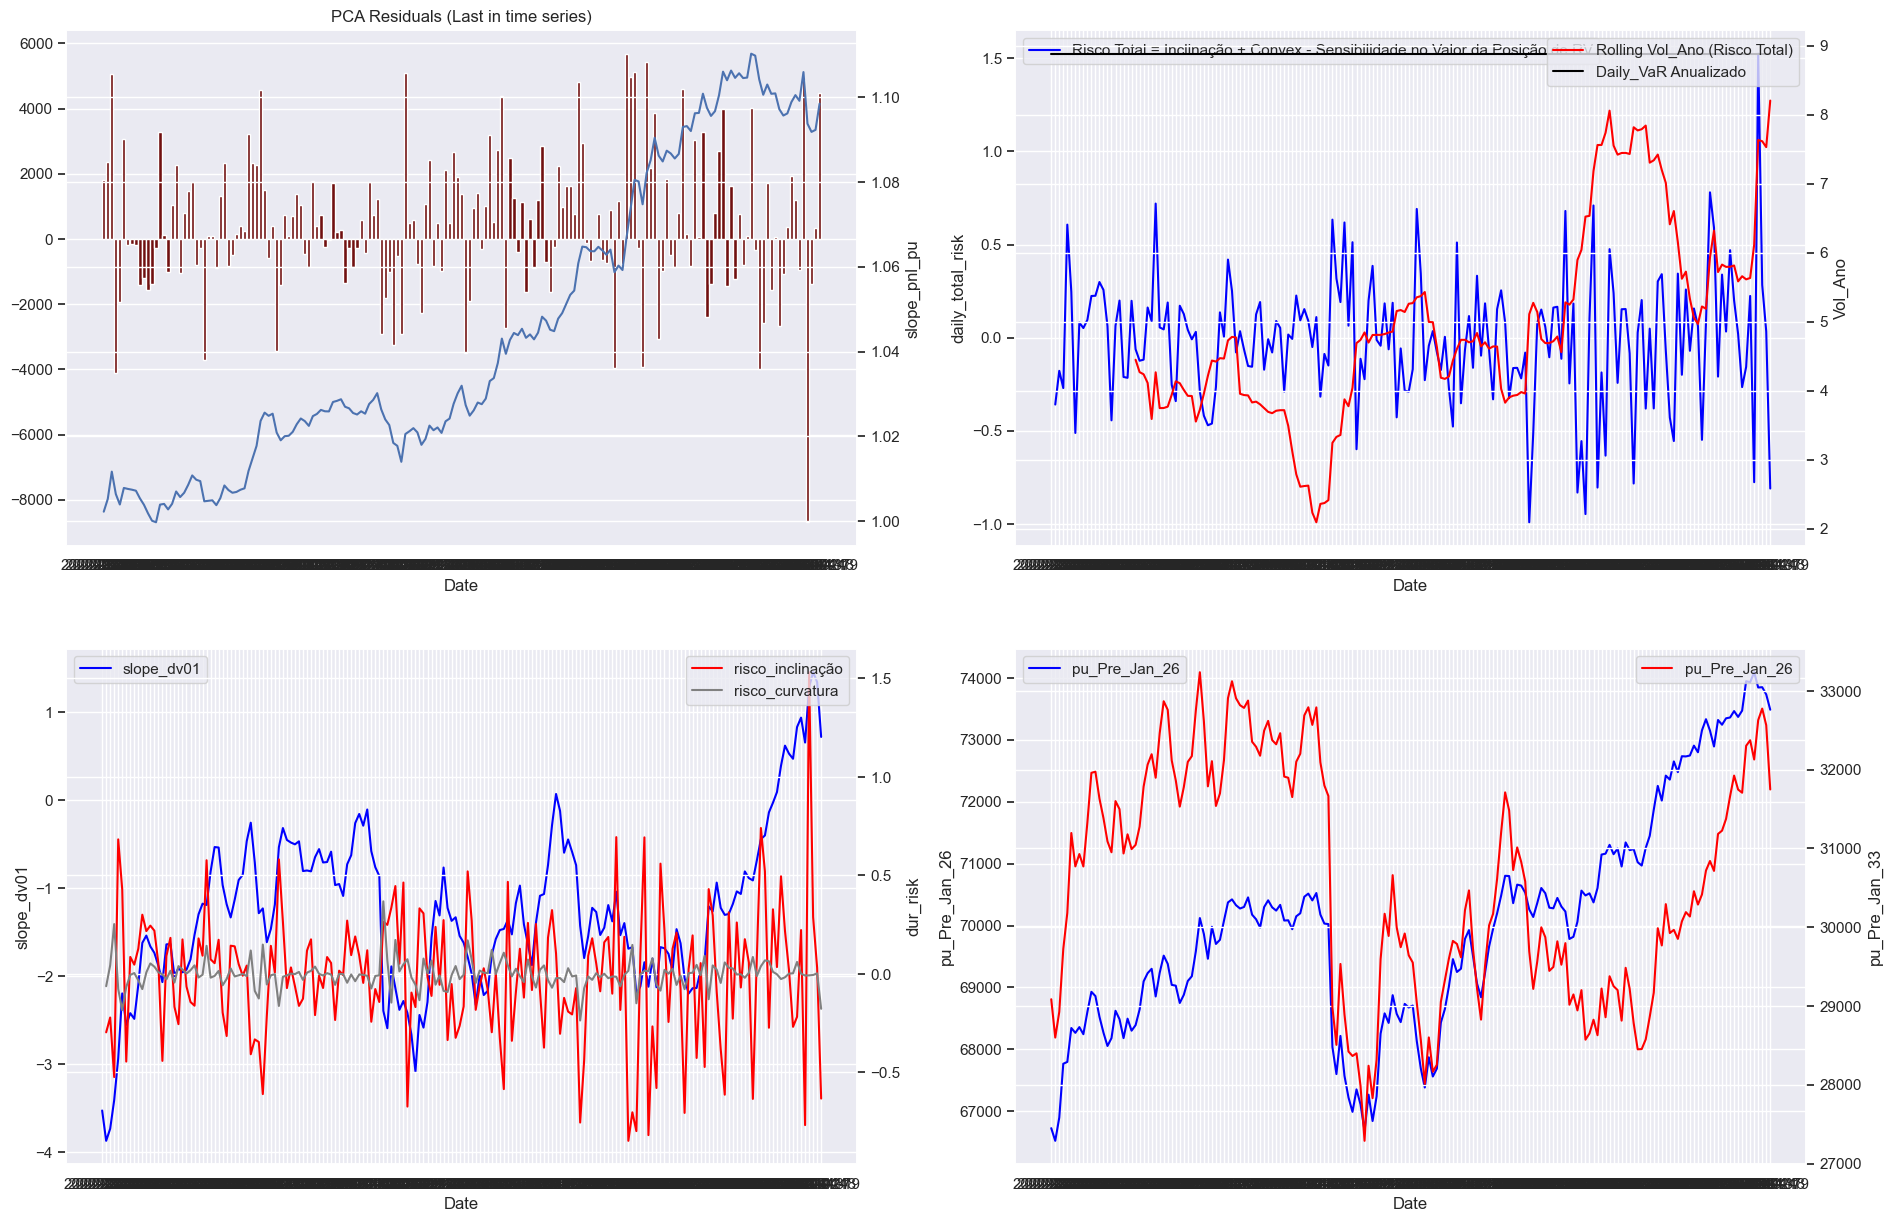

In [41]:
# Crie um gráfico com 2 linhas e 2 colunas
fig, axs = plt.subplots(2, 2, figsize=(20,14))


ax = sns.barplot(x=relative_value_position[['slope_pnl_pu']].index, y=relative_value_position[['slope_pnl_pu']].values.flatten(), color='maroon', ax=axs[0, 0])
ax.set_title('PCA Residuals (Last in time series)')
ax2 = ax.twinx()
ax2 = sns.lineplot(data=(relative_value_position.slope_pnl_pu / pu_slope_inicial + 1).cumprod(), color="b", ax=ax2)


ax = sns.lineplot(data=relative_value_position["total_risk"], label="Risco Total = Inclinação + Convex - Sensibilidade no Valor da Posição de RV", color="blue", ax=axs[0, 1])
ax.set_ylabel("daily_total_risk")
ax2 = ax.twinx()
ax2 = sns.lineplot(data=relative_value_position["std_rolling"], label="Rolling Vol_Ano (Risco Total)", color="red", ax=ax2)
ax2.set_ylabel("Vol_Ano")
ax2 = sns.lineplot(data=relative_value_position["Daily_VaR"]* np.sqrt(252) , label="Daily_VaR Anualizado", color="black", ax=ax2)
#ax.axhline(relative_value_position["Daily_VaR"].values, ls='--')
ax.legend(loc="upper left")
ax2.legend(loc="upper right")


ax = sns.lineplot(data=relative_value_position["slope_dv01"], label="slope_dv01", color="blue", ax=axs[1, 0])
ax2 = ax.twinx()
ax2 = sns.lineplot(data=relative_value_position["dur_risk"], label="risco_inclinação", color="red",ax=ax2)
ax2 = sns.lineplot(data=relative_value_position["convex_risk"], label="risco_curvatura", color="gray", ax=ax2)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")


ax = sns.lineplot(data=relative_value_position[f'pu_{vert_1}'], label=f'pu_{vert_1}', color="blue", ax=axs[1, 1])
ax2 = ax.twinx()
ax2 = sns.lineplot(data=relative_value_position[f'pu_{vert_2}'], label=f'pu_{vert_1}', color="red",ax=ax2)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

##### determine holding period

In [ ]:
def ornstein_uhlenbeck_mle(data, dt):
    
    n_samples = len(data)
    def log_likelihood(theta):
        lamb = theta[0]
        mu = theta[1]
        sigma = theta[2]
        sum_squared_diff = np.sum(np.diff(data - mu) ** 2)
        log_likelihood = -n_samples * np.log(lamb) - n_samples * np.log(np.pi) - sum_squared_diff / (lamb * dt) \
            - np.sum(np.log(sigma * np.sqrt(1 - np.exp(-2 * lamb * dt))))
        return -log_likelihood
 
 ''
    # Find optimal parameters using maximum likelihood estimation
    initial_guess = [1, np.mean(data), np.std(data)]
    bounds = [(0, None), (None, None), (0, None)]
    result = minimize(log_likelihood, initial_guess, bounds=bounds)
    theta = result.x
    lamb = theta[0]
    mu = theta[1]    
    sigma = theta[2] / np.sqrt(2 * lamb)

    return mu, lamb, sigma


In [ ]:
def simulate_ou_process(df_str, T):    
    
    _df = np.array(df_str)
    rv_params = ornstein_uhlenbeck_mle(_df, dt=1)
    Mean = rv_params[0]
    Lambda = rv_params[1]
    Sigma2 = rv_params[2]
    
    date_array = []
    expected = []
    upper_2s = []
    lower_2s = []    

    dt = 1
    t = np.arange(0, T, dt)
    res = pd.DataFrame()
    
    dW = np.sqrt(dt) * np.random.randn(len(t))    
    for t in range(len(t)):
        _dt = df_str.index[-1]
        date_array.append(_dt + datetime.timedelta(days = t))
        if t == 0:
            expected.append(df_str.iloc[-1][0])            
        else:
            expected.append( expected[t-1] + Lambda * (Mean - expected[t-1]) * dt + Sigma2 * dW[t])        
        drift = 0.5 * Sigma2 / Lambda * (1 - np.exp(-2 * Lambda * t))        
        upper_2s.append(expected[t] + 2 * np.sqrt(drift))
        lower_2s.append(expected[t] - 2 * np.sqrt(drift))
        
    res['expect'] = expected
    res['2sig_upper'] = upper_2s
    res['2sig_lower'] = lower_2s
    
    return res

In [ ]:
T = 90
res = simulate_ou_process(df_dif_res_ts, T)
res.plot()

In [ ]:
from scipy.integrate import quad


# Define a function that simulates the trading strategy using the OU process
def simulate_trading_strategy(X, entry_threshold, stop_loss_level, take_profit_level):
   
    res = simulate_ou_process(df_dif_res_ts, T)
    n = len(res)
    pos = np.zeros(n)
    stop_loss = np.zeros(n)
    take_profit = np.zeros(n)
    
    upper_barrier = res[['2sig_upper']]
    lower_barrier = res[['2sig_lower']]
    
    for i in range(1, n):
        if X[i-1] < entry_threshold and X[i] >= entry_threshold:
        if X[i-1] < lower_barrier[i] and X[i] >= lower_barrier[i]:
            pos[i] = 1
            stop_loss[i] = stop_loss_level
            take_profit[i] = take_profit_level
        elif pos[i-1] == 1:
            if X[i] <= stop_loss[i-1]:
                pos[i] = 0
            elif X[i] >= take_profit[i-1]:
                pos[i] = 0
            else:
                pos[i] = 1
                stop_loss[i] = stop_loss[i-1]
                take_profit[i] = take_profit[i-1]
    
    return pos


In [ ]:
# Define a function that estimates the optimal holding horizon using Monte Carlo simulation and the first-passage time
def estimate_optimal_holding_horizon(theta, mu, sigma, X0, dt, T, entry_threshold, stop_loss_level, take_profit_level, n_simulations):
    fpt_list = []
    for i in range(n_simulations):
        X = simulate_ou_process(theta, mu, sigma, X0, dt, T)
        pos = simulate_trading_strategy(X, entry_threshold, stop_loss_level, take_profit_level)
        crossing_idx = np.argmax(X >= entry_threshold)
        if crossing_idx > 0:
            crossing_time = crossing_idx * dt
            fpt_density = lambda t: 2 * (theta * (mu - stop_loss_level) / sigma ** 2) * np.exp(-((theta * (mu - stop_loss_level) / sigma ** 2) ** 2) * t) / np.sqrt(np.pi * (theta * (mu - stop_loss_level) / sigma ** 2) ** 3 * t)
            fpt, _ = quad(fpt_density, crossing_time, np.inf)
            fpt_list.append(fpt)
    if len(fpt_list) > 0:
        return np.mean(fpt_list)
    else:
        return np.nan

# Call the function to estimate the optimal holding horizon
optimal_holding_horizon = estimate_optimal_holding_horizon(theta, mu, sigma, X0, dt=0.01, T=10, entry_threshold=entry_threshold, stop_loss_level=stop_loss_level, take

In [152]:
from scipy.interpolate import interp1d

# aproximação de derivada central
# Exemplo de dados de vencimentos e taxas de juros pré-fixados
vencimentos = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20])
taxas = np.array([3.5, 3.6, 3.75, 4.1, 4.3, 4.7, 5, 5.4, 6.1]) / 100

# Interpolação linear dos dados
curva_juros = interp1d(vencimentos, taxas, kind='linear')

def dv01(vencimento, taxa, delta=0.0001):
    #taxa = curva_juros(vencimento)
    taxa_positiva = taxa + delta
    taxa_negativa = taxa - delta

    # Calculando o valor presente dos fluxos de caixa
    pv_atual = (1 + taxa) ** (-vencimento)
    pv_positivo = (1 + taxa_positiva) ** (-vencimento/252)
    pv_negativo = (1 + taxa_negativa) ** (-vencimento/252)

    # Calculando a variação do valor presente
    var_pv = pv_positivo - pv_negativo

    # Dividindo a variação do valor presente pela variação da taxa de juros
    dv01 = var_pv / (2 * delta)
    
    return dv01

# Exemplo: calcular DV01 para um título com vencimento de 5 anos
vencimento_alvo = 5
resultado_dv01 = dv01(vencimento_alvo, curva_juros(vencimento_alvo))
print(f"O DV01 para o título com vencimento de {vencimento_alvo} anos é {resultado_dv01:.6f}")


O DV01 para o título com vencimento de 5 anos é -0.018933


In [56]:
delta=0.0001

In [58]:
vencimento = 10
curva_juros = interp1d(vencimentos, taxas, kind='linear')
taxa_atual = curva_juros(vencimento)
taxa_atual

array(0.054)

In [59]:
taxa_positiva = taxa_atual + delta
taxa_negativa = taxa_atual - delta
taxa_positiva

0.05410000000000001

In [62]:
pv_atual = (1 + taxa_atual) ** (-vencimento)
pv_positivo = (1 + taxa_positiva) ** (-vencimento)
pv_negativo = (1 + taxa_negativa) ** (-vencimento)

print(pv_atual)
print(pv_positivo)
print(pv_negativo)

0.5910087234515211
0.5904482866020723
0.5915697455024361
